# End-to-End Demo: Stimulus 鈫?Rate 鈫?Spikes 鈫?Output

This notebook builds a visual stimulus, evaluates an LGN neuron with both backends (BMTK vs BrainState/JAX),
compares numerical responses, benchmarks runtime, generates Poisson spikes, and writes CSV/H5 outputs.

In [1]:
import os, sys, time, statistics as stats
import numpy as np
import matplotlib.pyplot as plt

# Ensure package root on path
PKG_ROOT = os.path.abspath(os.path.join('..'))
if PKG_ROOT not in sys.path: sys.path.insert(0, PKG_ROOT)

from brainlgn_x.stimuli import drifting_grating, full_field_flash
from brainlgn_x.filters import GaussianSpatialFilter, TemporalFilterCosineBump, SpatioTemporalFilter
from brainlgn_x.transfer import ScalarTransferFunction
from brainlgn_x.neuron import LGNNeuron
from brainlgn_x.poisson import generate_inhomogeneous_poisson
from brainlgn_x.io_output import write_spikes_csv, write_spikes_h5, write_rates_h5

try:
    import jax# noqa
    HAVE_JAX = True
except Exception:
    HAVE_JAX = False


## 1) Build stimulus (drifting grating)

Stimulus shape: (750, 96, 192) frame_rate: 1000.0


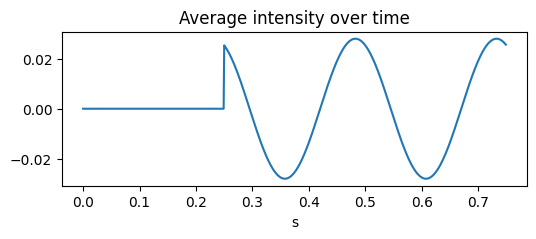

In [2]:
row, col = 96, 192
frame_rate = 1000.0
gray = 0.25
duration = 0.5
cpd, tf, theta, contrast = 0.04, 4.0, 0.0, 0.8
movie = drifting_grating(row, col, frame_rate, duration, gray_screen=gray, cpd=cpd, temporal_f=tf, theta=theta, contrast=contrast)
print('Stimulus shape:', movie.shape, 'frame_rate:', movie.frame_rate)
# Quick visualization: average intensity over time
avg_t = movie.as_array().mean(axis=(1,2))
plt.figure(figsize=(6,2)); plt.plot(movie.t_range, avg_t); plt.title('Average intensity over time'); plt.xlabel('s'); plt.show()


## 2) Build an LGN neuron (ON, ReLU with bias)

In [3]:
# Spatial filter
spatial = GaussianSpatialFilter(translate=(0.0, 0.0), sigma=(2.0, 2.0))
# Temporal filter (cosine bumps)
temporal = TemporalFilterCosineBump(weights=(0.6, -0.4), kpeaks=(15.0, 45.0), delays=(0,0))
# Linear amplitude decides ON/OFF (positive ON)
amplitude = 2.0
# Transfer: ReLU with bias
bias = 1.0
transfer = ScalarTransferFunction(f'Max(0, s + {bias})')
neuron = LGNNeuron(spatial, temporal, transfer, amplitude=amplitude)
print('Neuron ready (ON)')


Neuron ready (ON)


## 3) Evaluate rates with both backends and compare parity

Parity (BS vs BMTK): MAE=4.057e-08, RMSE=9.080e-08, MaxAbs=5.796e-07, Corr=1.000000


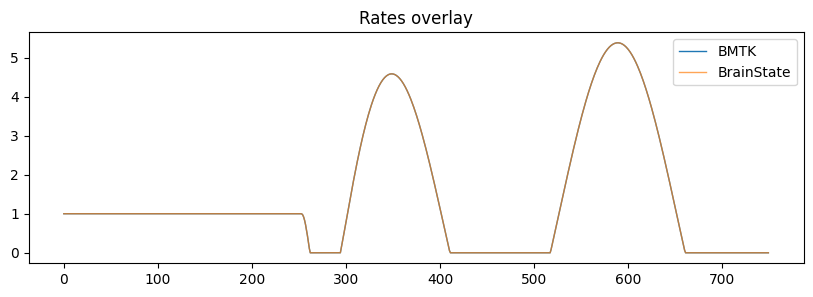

In [4]:
rates_bmtk = neuron.evaluate(movie.as_array(), separable=True, frame_rate=movie.frame_rate, backend='bmtk')
if HAVE_JAX:
    rates_bs = neuron.evaluate(movie.as_array(), separable=True, frame_rate=movie.frame_rate, backend='brainstate')
else:
    rates_bs = rates_bmtk

diff = rates_bs - rates_bmtk
mae  = np.mean(np.abs(diff))
rmse = np.sqrt(np.mean(diff**2))
mx   = np.max(np.abs(diff))
corr = np.corrcoef(rates_bmtk, rates_bs)[0,1] if rates_bmtk.size>1 else 1.0
print(f'Parity (BS vs BMTK): MAE={mae:.3e}, RMSE={rmse:.3e}, MaxAbs={mx:.3e}, Corr={corr:.6f}')

plt.figure(figsize=(10,3))
plt.plot(rates_bmtk, label='BMTK', lw=1)
plt.plot(rates_bs,   label='BrainState', lw=1, alpha=0.7)
plt.legend(); plt.title('Rates overlay'); plt.show()


## 4) Benchmark runtime (separable)

In [5]:
def bench(fn, repeats=5, warmup=1):
    for _ in range(warmup): fn()
    times=[]
    for _ in range(repeats):
        t0=time.perf_counter(); fn(); times.append(time.perf_counter()-t0)
    return {'mean': stats.mean(times), 'stdev': (stats.pstdev(times) if len(times)>1 else 0.0), 'min': min(times), 'max': max(times)}

res_bmtk = bench(lambda: neuron.evaluate(movie.as_array(), separable=True, frame_rate=movie.frame_rate, backend='bmtk'), repeats=5, warmup=1)
if HAVE_JAX:
    res_bs   = bench(lambda: neuron.evaluate(movie.as_array(), separable=True, frame_rate=movie.frame_rate, backend='brainstate'), repeats=5, warmup=1)
else:
    res_bs   = res_bmtk
print('Timing BMTK :', res_bmtk)
print('Timing BS   :', res_bs)


Timing BMTK : {'mean': 0.007509699993534014, 'stdev': 0.0003430422478832014, 'min': 0.007056200003717095, 'max': 0.00790129997767508}
Timing BS   : {'mean': 0.04148785999859683, 'stdev': 0.0025336271344662386, 'min': 0.03715990000637248, 'max': 0.04428659999393858}


## 5) Generate Poisson spikes and write outputs

Generated spikes: 1


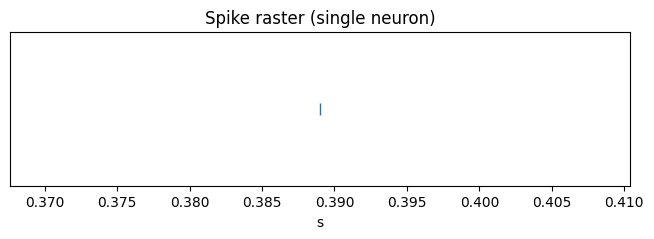

Wrote outputs to: c:\Users\76629\OneDrive\brain\repos\brainlgn\brainlgn-X\notebooks\_outputs


In [6]:
# Choose one backend's rates for spikes (here BrainState if available)
rates = rates_bs if HAVE_JAX else rates_bmtk
dt = 1.0 / movie.frame_rate
gids, times = generate_inhomogeneous_poisson(rates, dt, base_seed=123)
print('Generated spikes:', len(times))
# Simple raster
plt.figure(figsize=(8,2))
plt.plot(times, np.zeros_like(times), '|', markersize=8)
plt.title('Spike raster (single neuron)'); plt.xlabel('s'); plt.yticks([]); plt.show()

# Outputs
out_dir = os.path.abspath('./_outputs')
os.makedirs(out_dir, exist_ok=True)
write_rates_h5(os.path.join(out_dir, 'rates.h5'), rates, movie.frame_rate)
write_spikes_csv(os.path.join(out_dir, 'spikes.csv'), gids, times)
write_spikes_h5(os.path.join(out_dir, 'spikes.h5'), gids, times)
print('Wrote outputs to:', out_dir)


## Compare spikes: BMTK vs BrainState (same stimulus)

In [ ]:
# Generate spikes for both backends using the same base_seed
from brainlgn_x.poisson import generate_inhomogeneous_poisson
base_seed = 777
dt = 1.0 / movie.frame_rate
sp_g_bmtk = generate_inhomogeneous_poisson(rates_bmtk, dt, base_seed=base_seed)
sp_g_bs   = generate_inhomogeneous_poisson(rates_bs,   dt, base_seed=base_seed)
g_bmtk, t_bmtk = sp_g_bmtk
g_bs,   t_bs   = sp_g_bs
fig, ax = plt.subplots(1,2, figsize=(12,2.8), sharey=True)
ax[0].plot(t_bmtk, np.zeros_like(t_bmtk), '|', markersize=8); ax[0].set_title('Spikes: BMTK'); ax[0].set_xlabel('s'); ax[0].set_yticks([])
ax[1].plot(t_bs,   np.zeros_like(t_bs),   '|', markersize=8); ax[1].set_title('Spikes: BrainState'); ax[1].set_xlabel('s'); ax[1].set_yticks([])
plt.tight_layout(); plt.show()